In [2]:
import pandas as pd 

uri = "approaches_history.json"
dados = pd.read_json(uri)

dados = dados.drop(columns=["atOneThousandAFE","lat","lng","altitude_agl"], axis=1)
dados["stabilized"] = dados["stabilized"]
dados["speedbrake"] = round(dados["speedbrake"],2)

parametersAtIF = dados.drop(columns=["stabilized","pitch","bank"],axis=1)
resultOfApproach = dados.stabilized


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

SEED = 50
np.random.seed(SEED)

treino_x, teste_x, treino_y, teste_y = train_test_split(parametersAtIF, resultOfApproach, test_size=0.15)

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

modelo = RandomForestClassifier(n_estimators = 500)
modelo.fit(treino_x,treino_y)

acuracia = modelo.score(teste_x,teste_y)
print("A acurácia foi %.2f%%" % (acuracia*100))

previsao_teste = modelo.predict(teste_x)


Treinaremos com 68 elementos e testaremos com 12 elementos
A acurácia foi 91.67%


=== Confusion Matrix ===
[[4 0]
 [1 7]]


=== Classification Report ===
              precision    recall  f1-score   support

       False       0.80      1.00      0.89         4
        True       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



=== All AUC Scores ===
[1.         1.         0.93333333 0.73333333 1.         1.
 1.         0.6        0.86666667 0.76666667]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8900000000000002


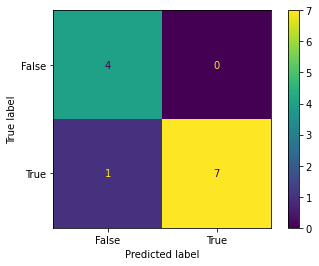

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

plot_confusion_matrix(modelo, teste_x, teste_y)
modelo_cv_score = cross_val_score(modelo, parametersAtIF, resultOfApproach, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(teste_y, previsao_teste))
print('\n')
print("=== Classification Report ===")
print(classification_report(teste_y, previsao_teste))
print('\n')
print("=== All AUC Scores ===")
print(modelo_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", modelo_cv_score.mean())



,altitude_msl,v_speed,gs,ias,gw,gear,speedbrake,flaps,stabilized
0,4700.0,0.0,200.0,190.0,64000.0,0.0,0.0,0.25,True
1,6500.0,-1500.0,130.0,120.0,60000.0,1.0,0.0,1.00,False
2,6500.0,-300.0,130.0,120.0,60000.0,1.0,1.0,1.00,False
3,5000.0,0.0,180.0,160.0,60000.0,1.0,1.0,1.00,True
4,10000.0,-2500.0,140.0,130.0,50000.0,0.0,1.0,0.75,False
5,8000.0,-3000.0,190.0,210.0,43000.0,0.0,1.0,0.00,False
6,5100.0,-200.0,300.0,290.0,64000.0,0.0,1.0,0.00,False
7,5100.0,-500.0,220.0,210.0,45000.0,0.0,0.0,0.00,False
8,5100.0,-500.0,220.0,210.0,45000.0,1.0,1.0,0.25,True
9,4700.0,-200.0,210.0,200.0,55600.0,1.0,1.0,0.25,True


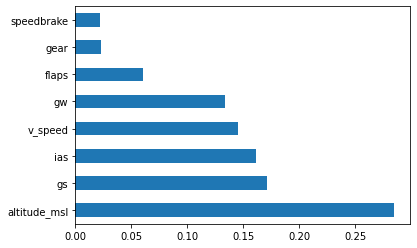

In [6]:
importances = modelo.feature_importances_
indices = np.argsort(importances)

feat_importances = pd.Series(modelo.feature_importances_, index=parametersAtIF.columns)
feat_importances.nlargest(8).plot(kind='barh')

#[altitude_msl, v_speed, gs, ias, gw, geardown, speedbrake, flaps]
our_test_values = [
    [4700,0,200,190,64000,0,0,0.25],
    [6500,-1500,130,120,60000,1,0,1.00],
    [6500,-300,130,120,60000,1,1,1.00],
    [5000,0,180,160,60000,1,1,1.00],
    [10000,-2500,140,130,50000,0,1,0.75],
    [8000,-3000,190,210,43000,0,1,0.0],
    [5100,-200,300,290,64000,0,1,0.00],
    [5100,-500,220,210,45000,0,0,0.00],
    [5100,-500,220,210,45000,1,1,0.25],
    [4700,-200,210,200,55600,1,1,0.25],
    [4700,-200,210,200,55600,1,1,0.25],
    [5100,-700,140,160,60600,1,1,0.50],
]
result_our_test = modelo.predict(our_test_values)
list(parametersAtIF)
result_our_test_table = pd.DataFrame(np.array(our_test_values), columns=list(parametersAtIF))
result_our_test_table["stabilized"] = result_our_test
result_our_test_table
#result_our_test_table.to_excel("output.xlsx")  

In [7]:
#   Aqui nós testamos para ver se o resultado da nossa clasificação anterior realmente é um número preciso
#   Como faremos isso? Vamos chutar o resultado mais frequente em todos os testes e ver se a acurácia é similar
from sklearn.dummy import DummyClassifier

classificador_bobo = DummyClassifier(strategy='most_frequent')
classificador_bobo.fit(treino_x,treino_y)
print("A acurácia da classificação boba foi %.2f%%" % (classificador_bobo.score(teste_x,teste_y)*100))


A acurácia da classificação boba foi 66.67%


In [8]:
from sklearn.preprocessing import StandardScaler

standard_scale = StandardScaler()
standard_scale.fit(parametersAtIF)

parametersAtIFWithSameScale = standard_scale.transform(parametersAtIF)
parametersAtIFWithSameScale = pd.DataFrame(data = parametersAtIFWithSameScale, columns = parametersAtIF.keys())
dados_plot = pd.concat([resultOfApproach,parametersAtIFWithSameScale],axis=1)
dados_plot = pd.melt(dados_plot, id_vars="stabilized",var_name="parameters",value_name="values")
dados_plot.head()

,stabilized,parameters,values
0,True,altitude_msl,-0.347795
1,False,altitude_msl,1.750605
2,False,altitude_msl,0.429077
3,True,altitude_msl,0.529874
4,True,altitude_msl,0.344962


<AxesSubplot:xlabel='parameters', ylabel='values'>

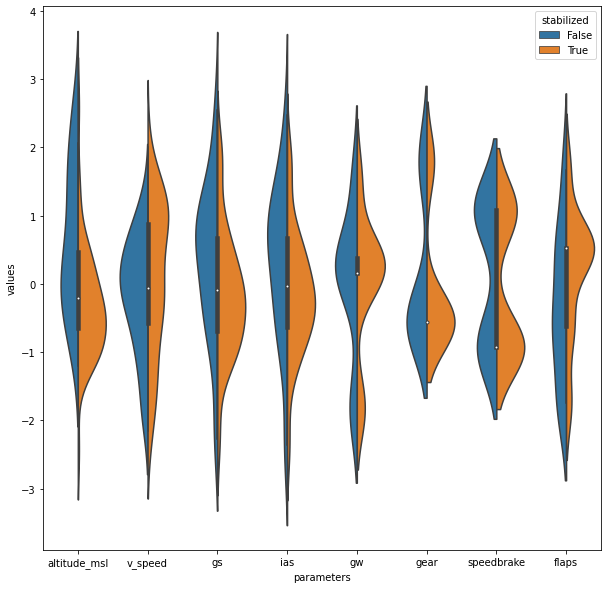

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.violinplot(x="parameters",y="values", hue="stabilized", data = dados_plot, split=True)

<AxesSubplot:>

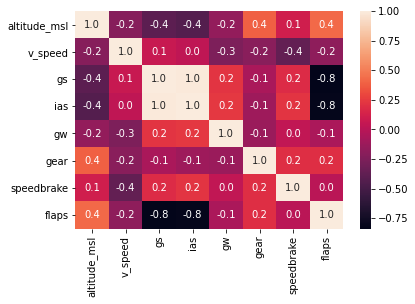

In [10]:

correlationArray = parametersAtIFWithSameScale.corr()
sns.heatmap(correlationArray, annot = True, fmt= ".1f")

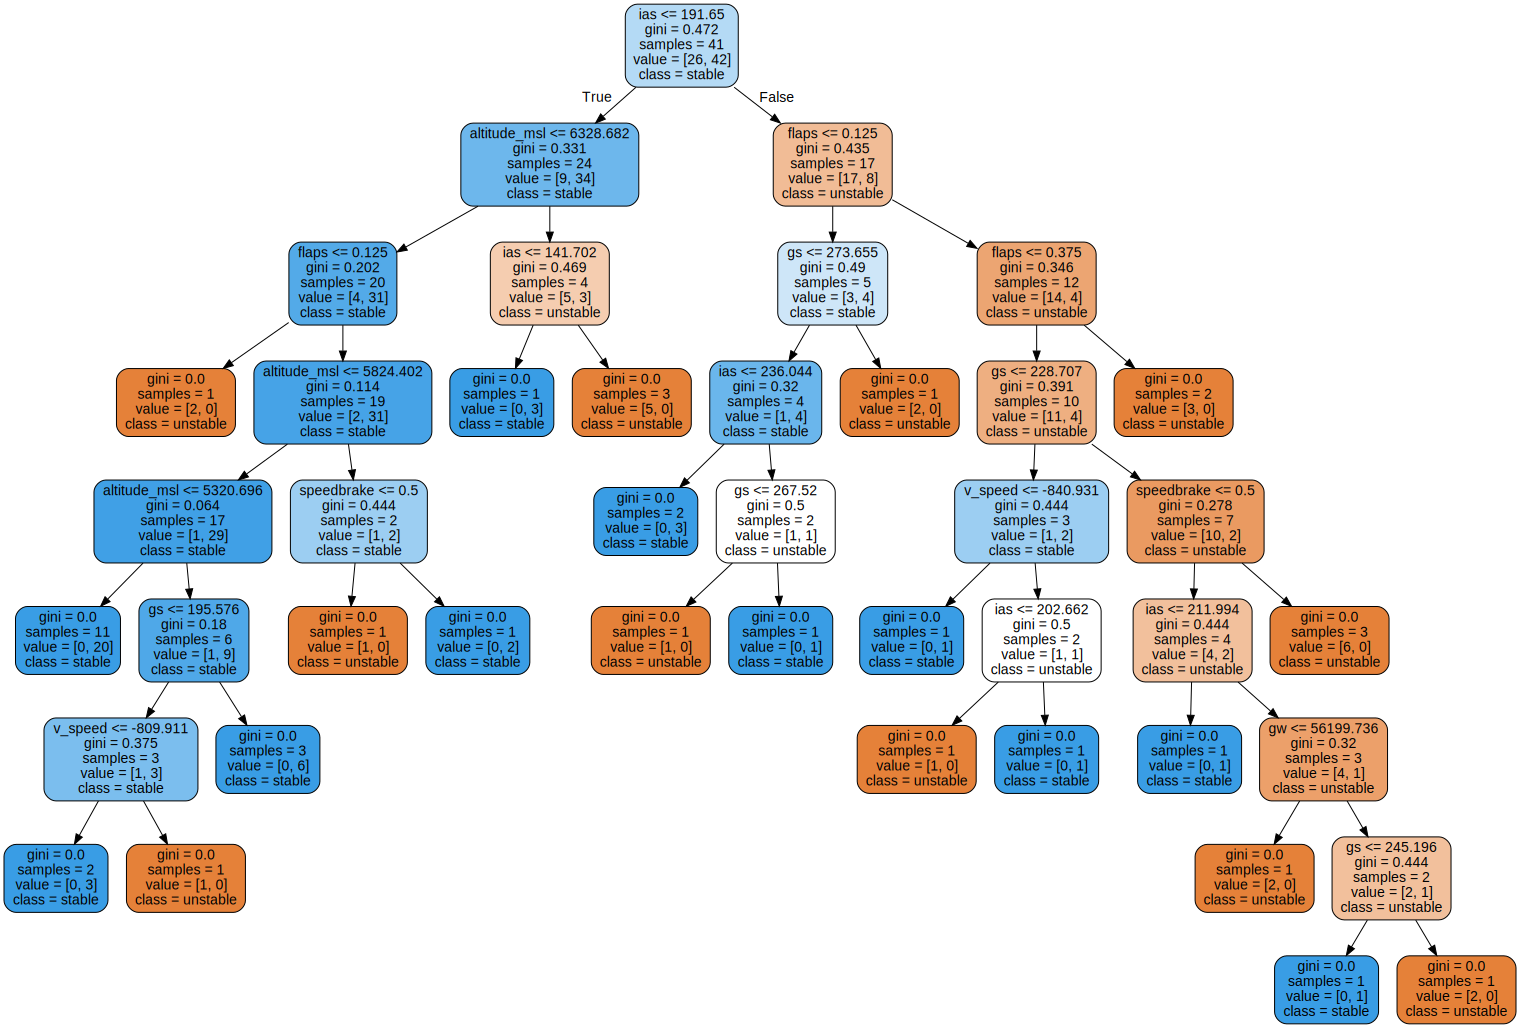

In [4]:
from sklearn.tree import export_graphviz
import graphviz
from graphviz import render


dot_data = export_graphviz(modelo.estimators_[1], out_file=None, feature_names=parametersAtIF.columns, filled=True, rounded=True, class_names=['unstable','stable'])
grafico = graphviz.Source(dot_data)
grafico